In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import healpy as hp
import pixell as px
from pixell import reproject
import camb
from classy import Class


In [11]:

fig = plt.figure()
fw = fig.get_figwidth()
fh = fig.get_figheight()
cmap = plt.cm.RdBu


<Figure size 432x288 with 0 Axes>

In [4]:
lmax=4000
ell=np.arange(0,lmax+1)
norm = ell * (ell+1) / (2*np.pi)


In [5]:
dl_pwl = ell**2 / (1e9 + ell**4) * 2e8
cl_pwl = dl_pwl
cl_pwl[1:] /= norm[1:]
#cl_pwl[0] = 0
#cl_pwl[1] = 0

In [6]:
def power_axes(ax1, ax2):
    ax1.set_xlabel("$\ell$")
    ax2.set_xlabel("$\ell$")
    ax1.set_ylabel("$C_\ell\ \ell (\ell+1) / 2\pi\ /\ \mu\mathrm{K^2}$")
    ax2.set_ylabel("$C_\ell\ \ell (\ell+1) / 2\pi\ /\ \mu\mathrm{K^2}$")
    ax1.set_xlim(-100, 3000)
    ax2.set_xlim(1, 10000)

(0.07999999872, 12649.086980166701)

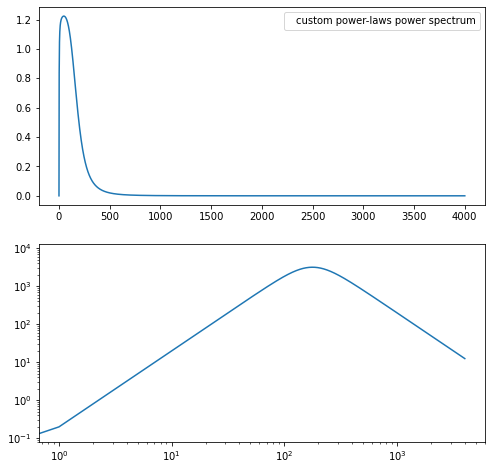

In [7]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot(211)
ax1.plot(ell, dl_pwl,  label="custom power-laws power spectrum")
ax1.legend(handlelength=0)

ax2 = plt.subplot(212)
ax2.loglog(ell, cl_pwl*norm)
ax2.set_ylim((cl_pwl*norm)[2]/10, (cl_pwl*norm).max()*4)



map mean: -1.2718150452983359 map rms: 69.22619252828541


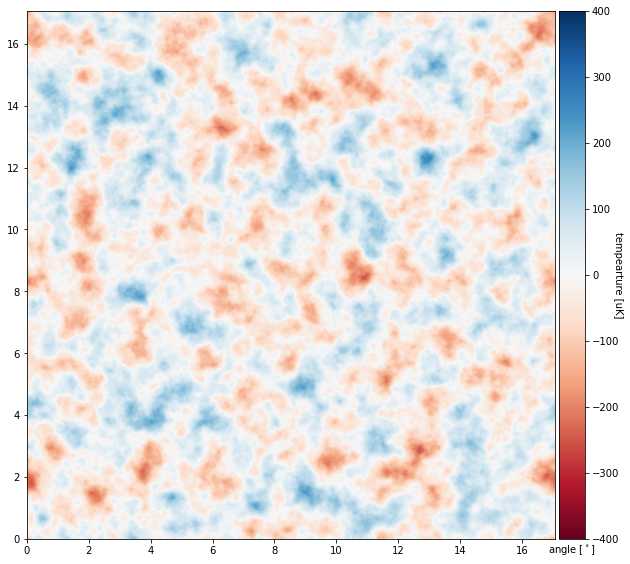

<Figure size 432x288 with 0 Axes>

In [12]:
## variables to set up the size of the map
N = 2**11  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_flat_map(N,pix_size,ell,ClTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    #ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    #ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    #ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
        
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    

    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_flat_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cmap)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    plt.show()
    return(0)
  ###############################

## make a CMB T map
pwl_map = make_flat_map(N,pix_size,ell,cl_pwl)
Plot_flat_Map(pwl_map,c_min,c_max,X_width,Y_width)
plt.savefig('cmb1.png')
plt.clf()
    

In [13]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from kymatio import Scattering2D
from PIL import Image
import os


In [216]:
src_img = np.array(pwl_map)
print("img shape: ", src_img.shape)


img shape:  (2048, 2048)


In [217]:
L = 1
J = 9
scattering = Scattering2D(J=J, shape=src_img.shape, L=L, max_order=2, frontend='numpy')


In [218]:
#src_img_tensor = src_img.astype(np.float32) / 255.

scat_coeffs = scattering(pwl_map)
print("coeffs shape: ", scat_coeffs.shape)

coeffs shape:  (46, 4, 4)


In [219]:
S0 = scat_coeffs[0,:,:]
S1 = scat_coeffs[1:J*L+1,:,:]
S2 = scat_coeffs[J*L+1:,:,:]


In [220]:
s1 = np.mean (S1 , axis = (1,2))
s2 = np.mean (S2 , axis = (1,2))

In [221]:
js = np.arange (J)
scale = 2*pix_size/0.75*(2**js)

Text(0.5, 1.0, 'S1 coefficients')

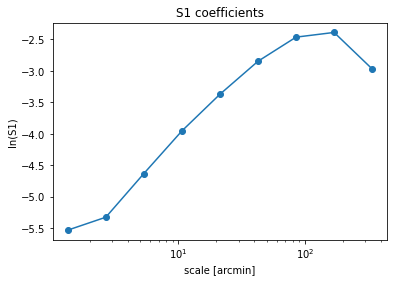

In [222]:
plt.plot(scale,np.log(s1_sym),marker='o')
plt.xscale('log')
plt.xlabel("scale [arcmin]")
plt.ylabel("ln(S1)")
plt.title("S1 coefficients")

map mean: 8.899730759785875 map rms: 72.26677436951535


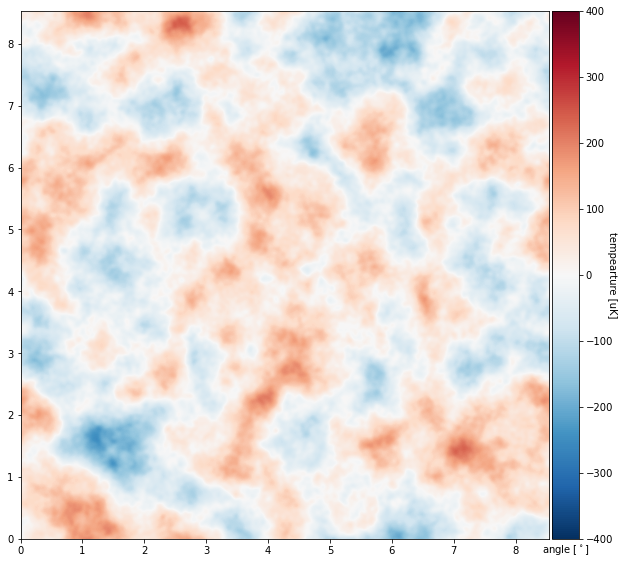

<Figure size 432x288 with 0 Axes>

In [14]:
## variables to set up the size of the map
N = 2**10  # this is the number of pixels in a linear dimension
            ## since we are using lots of FFTs this should be a factor of 2^N
pix_size  = 0.5 # size of a pixel in arcminutes

## variables to set up the map plots
c_min = -400  # minimum for color bar
c_max = 400   # maximum for color bar
X_width = N*pix_size/60.  # horizontal map width in degrees
Y_width = N*pix_size/60.  # vertical map width in degrees


def make_flat_map(N,pix_size,ell,ClTT):
    "makes a realization of a simulated CMB sky map given an input DlTT as a function of ell," 
    "the pixel size (pix_size) required and the number N of pixels in the linear dimension."
    #np.random.seed(100)
    # convert Dl to Cl
    #ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
    #ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
    #ClTT[1] = 0.

    # make a 2D real space coordinate system
    onesvec = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.) # create an array of size N between -0.5 and +0.5
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    X = np.outer(onesvec,inds) 
    # compute the transpose for the y dimension
    Y = np.transpose(X)
    # radial component R
    R = np.sqrt(X**2. + Y**2.)
    
    # now make a 2D CMB power spectrum
    pix_to_rad = (pix_size/60. * np.pi/180.) # going from pix_size in arcmins to degrees and then degrees to radians
    ell_scale_factor = 2. * np.pi /pix_to_rad  # now relating the angular size in radians to multipoles
    ell2d = R * ell_scale_factor # making a fourier space analogue to the real space R vector
    ClTT_expanded = np.zeros(int(ell2d.max())+1) 
    # making an expanded Cl spectrum (of zeros) that goes all the way to the size of the 2D ell vector
    ClTT_expanded[0:(ClTT.size)] = ClTT # fill in the Cls until the max of the ClTT vector

    # the 2D Cl spectrum is defined on the multiple vector set by the pixel scale
    CLTT2d = ClTT_expanded[ell2d.astype(int)] 
    #plt.imshow(np.log(CLTT2d))
        
    
    # now make a realization of the CMB with the given power spectrum in real space
    random_array_for_T = np.random.normal(0,1,(N,N))
    FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
    FT_2d = np.sqrt(CLTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2
    plt.imshow(np.real(FT_2d))
        
    
    ## make a plot of the 2D cmb simulated map in Fourier space, note the x and y axis labels need to be fixed
    #Plot_CMB_Map(np.real(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),0,np.max(np.conj(FT_2d)*FT_2d*ell2d * (ell2d+1)/2/np.pi),ell2d.max(),ell2d.max())  ###
    

    # move back from ell space to real space
    CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
    # move back to pixel space for the map
    CMB_T = CMB_T/(pix_size /60.* np.pi/180.)
    # we only want to plot the real component
    CMB_T = np.real(CMB_T)

    ## return the map
    return(CMB_T)
  ###############################

def Plot_flat_Map(Map_to_Plot,c_min,c_max,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.gcf().set_size_inches(10, 10)
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    #cbar = plt.colorbar()
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('tempearture [uK]', rotation=270)
    plt.show()
    return(0)
  ###############################

## make a CMB T map
pwl_map_1 = make_flat_map(N,pix_size,ell,cl_pwl)
Plot_flat_Map(pwl_map_1,c_min,c_max,X_width,Y_width)
plt.savefig('cmb1.png')
plt.clf()
    

In [17]:
from pixell import enmap, utils

In [18]:
imgsize_arcmin = N * pix_size
imgsize_arcmin

512.0

In [21]:
box = np.array([[-imgsize_arcmin//2, imgsize_arcmin//2], [imgsize_arcmin//2, -imgsize_arcmin//2]]) * utils.arcmin
shape1024, wcs1024 = enmap.geometry(pos=box, res=pix_size*utils.arcmin, proj='car')
imap1024 = enmap.ndmap(pw, wcs=wcs1024)


In [22]:
fmap_pwl_1024 = reproject.healpix_from_enmap(imap1024, lmax = 4000 , nside = 1024 )


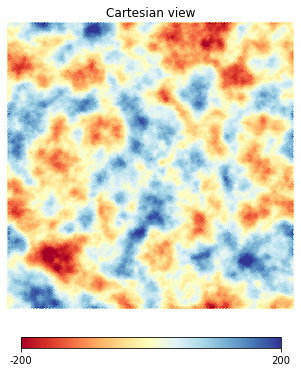

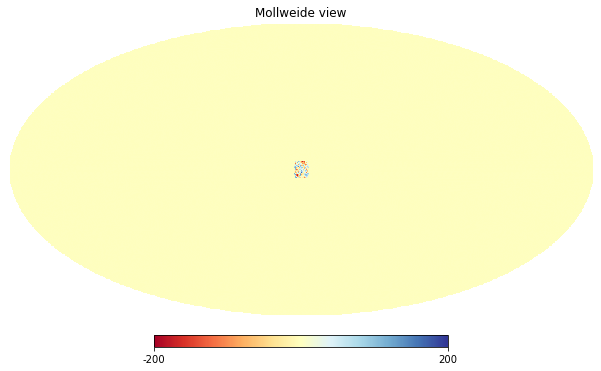

In [30]:

# Plot using healpy
lonra = np.sort(imap1024.box()[:, 1])/utils.degree
latra = np.sort(imap1024.box()[:, 0])/utils.degree
rang = 200

mapp = hp.cartview(fmap_pwl_1024, lonra = lonra, latra = latra, min = -rang, max = rang, 
            cmap = cm.get_cmap('RdYlBu'))

hp.mollview(fmap_pwl_1024, min = -rang, max = rang, 
            cmap = cm.get_cmap('RdYlBu'))

In [79]:
def gabor(freq,sigma,theta):
    
    arg=-(theta**2)/(2*sigma*sigma) + 1.j * freq*theta
    
    g=np.exp(arg)
    g/=(2*np.pi*sigma*sigma)
    return g

In [80]:
def morlet(f,sigma,theta):
    wv=gabor(f,sigma,theta)
    wvm=gabor(0,sigma, theta)
    B=np.sum(wv)/np.sum(wvm)
    mor=wv-B*wvm
    return mor

None


In [ ]:
%%time

theta=np.linspace(0,np.pi,5000)

S1=np.zeros((8))

i1=[]

for j1 in range(8):
    
    sigma1 = (0.8*2**j1) # multiplied by resolution in radians
    freq1=(3.0*np.pi) /(4.0*2**j1) #divided by resolution in radians
    
    #filter 1
    mor=morlet(freq1,sigma1,theta)
    mor_l=hp.beam2bl(mor.real,theta,lmax=lmax) 
    
    #convolving the map with filter 1
    mapalm=hp.map2alm(hmap,lmax=lmax,use_pixel_weights=True)
    nalm=hp.almxfl(mapalm,mor_l)
    I1=hp.alm2map(nalm,nside,lmax)
    
    #modulus
    I1=np.abs(I1)
    
    i1.append(I1)
    
    #Gaussian filter for S1
    phi1=gabor(0,sigma1, theta)
    gab_l=hp.beam2bl(phi1.real,theta,lmax=lmax)
    
    #Convolving with gaussian filter to get S1
    I1alm=hp.map2alm(I1,lmax=lmax,use_pixel_weights=True)
    nI1alm=hp.almxfl(I1alm,gab_l)
    S1map=hp.alm2map(nI1alm,nside,lmax)
    
    #Averaging the entire map
    S1[j1]=np.mean(S1map)